In [1]:
from fastai.basics import *
from itertools import accumulate
from fastai.vision.all import *

### A Quick Overview

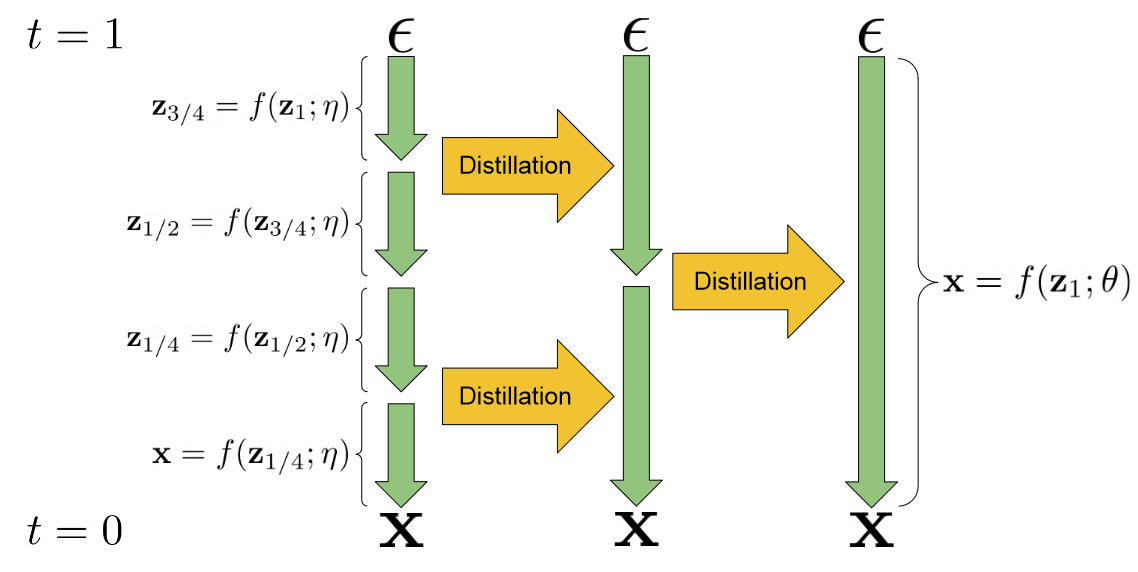

---

### $\tilde x$ is our target

:::: {.columns}

::: {.column width="50%"}

- We take two steps of DDIM
- Then $\tilde x$ is the image associated with taking two steps. 
- The target of our distilled model is the output of our original diffusion model taking two ddim steps. 
- We will cover $w()$ later

:::

::: {.column width="50%"}

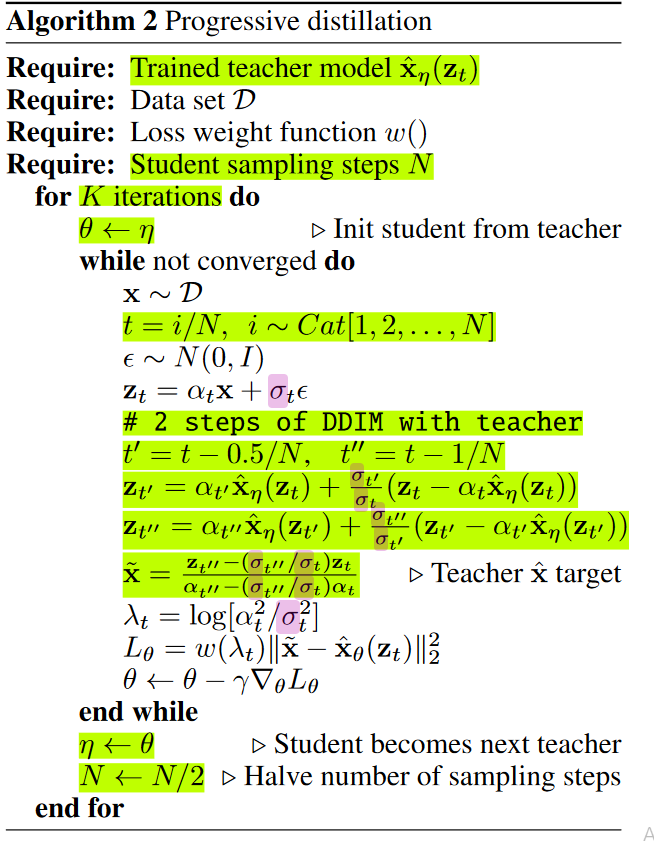

:::

::::

---

### Questions so far?

---

### Why is $\tilde x$ our target, and not $\epsilon$?

---

### Break down of relationship between x and $\epsilon$

In the case of a single timestep $||\epsilon_\theta(x_T)-\epsilon||^2_2$, could be optimized by an identity, and is not particularly useful. As our  number of steps decreases to 4, this step becomes 1/4 of our total steps. ($a_T\simeq0$)

:::: {.columns}

::: {.column width="50%"}

$\hat{x}_\theta(z_t) = \frac{1}{\alpha_t}(z_t-\sigma_t\hat{\epsilon}_\theta(z_t))$

Our Options:

- Just predict $x$ directly.
- Predict $x$ and $\epsilon$
- Predict $v = \alpha_t\epsilon+ \sigma x$

:::

::: {.column width="50%"}

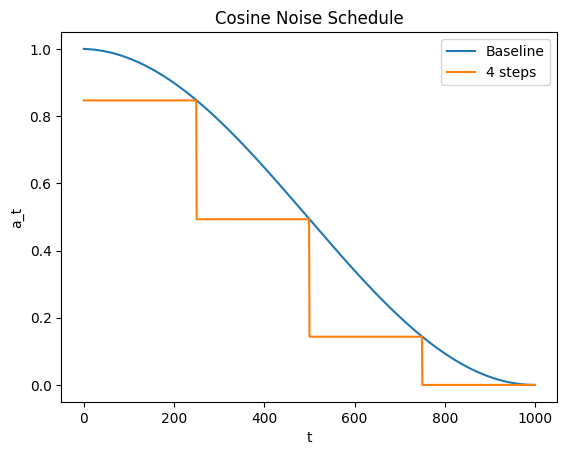

In [22]:
plt.plot(range(Bt.shape[0]),cos_sched(Bt))
plt.plot(range(Bt.shape[0]),cos_sched(Bt)[[250,500,750,999]].repeat_interleave(250))
plt.ylabel('a_t')
plt.xlabel('t')
plt.title('Cosine Noise Schedule')
plt.legend(['Baseline','4 steps']);

:::

::::

---

### $w$() is 0! 

In [2]:
s=0.008 #from Improved Denoising Diffusion Probabilistic Models
def cos_sched(at): 
    at = torch.linspace(0,1,at.shape[0])
    return torch.cos((at+s)/(1+s)*torch.pi/2)**2
def continuous_weights(at):
    weights = -snr(at[1:])/(snr(at[1:])-snr(at[:-1]))
    return torch.cat((weights[0:1],weights))
def snr(at): return at/(1-at)
Bt=torch.linspace(1e-4,0.02,1000)

$w()$ is 0, or very close to 0 near 0 and T. This problem becomes more aparent when we decrease the number of steps to 4. Our weights $w$ becomes almost 0 for one of our 4 steps!

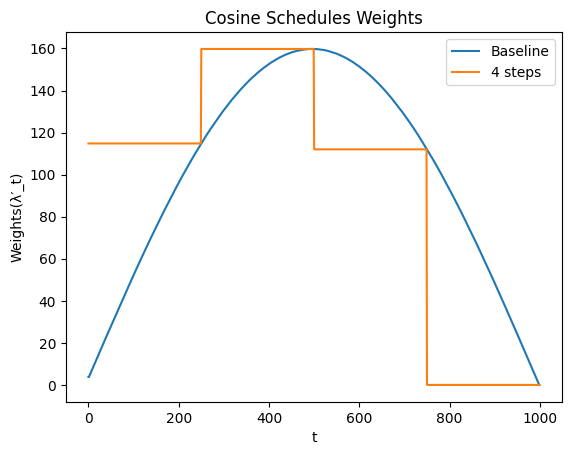

In [24]:
#plt.xscale('log')
#plt.xlim(left=1e-8,right=1e4)
plt.plot(range(Bt.shape[0]),continuous_weights(cos_sched(Bt)))
plt.plot(range(Bt.shape[0]),continuous_weights(cos_sched(Bt))[[250,500,750,999]].repeat_interleave(250))
plt.ylabel('Weights(λ′_t)')
plt.xlabel('t')
plt.title('Cosine Schedules Weights')
plt.legend(['Baseline','4 steps']);

---

### Alternative Weights

$L_\theta = max(\frac{\alpha_t^2}{\sigma_t^2},1)||\hat x-x_t ||_2^2$ 'truncated SNR weighting'

$L_\theta=(1+\frac{\alpha_t^2}{\sigma_t^2})||\hat x-x_t ||_2^2$ 'SNR+1 weighting'

I just clipped the weights. 

In [ ]:
#| echo: true
continuous_weights(CosineNoiseSchedule().alpha_bar).clip(min=1)

---

### Results

Notice the evaluations at powers of 2. 

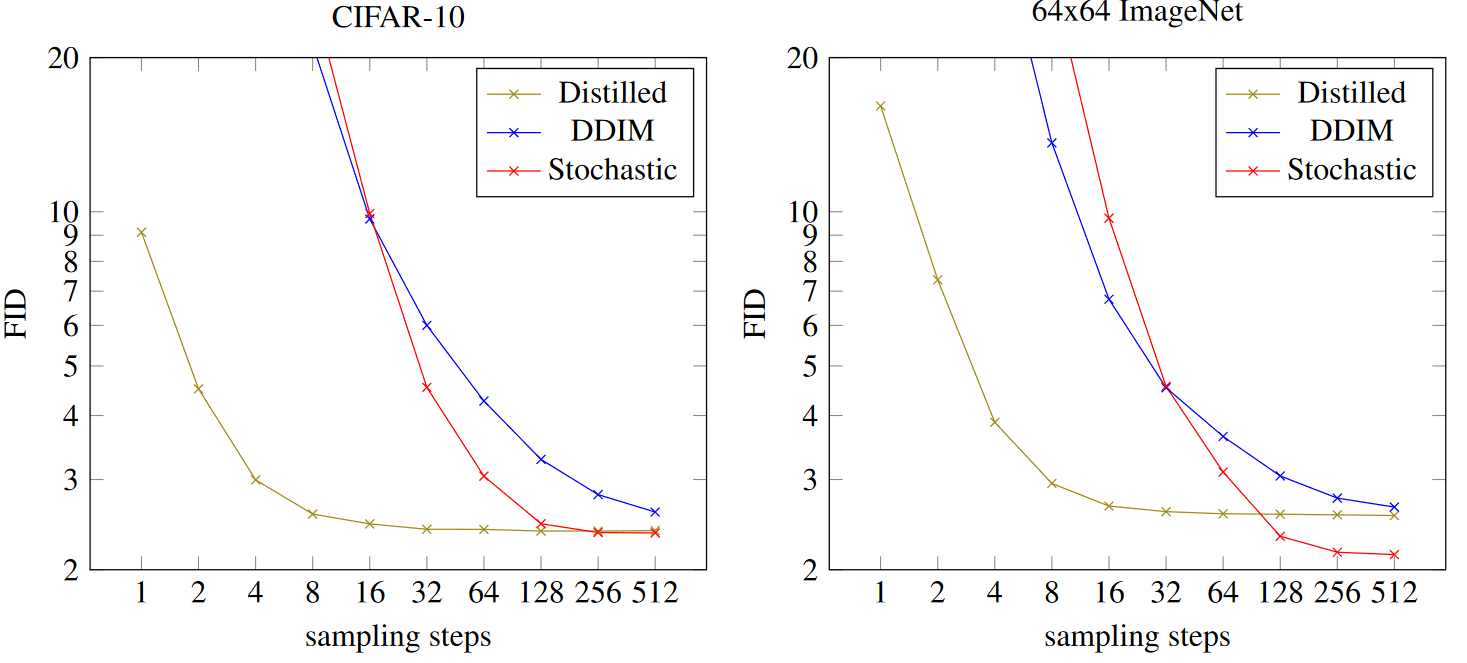

---

### Derivation of the distillation target

from Appendix G

:::: {.columns}

::: {.column width="50%"}

$N$ : student sampling steps

$t' = t-\frac{0.5}{N}$ : 1 teacher step, 1/2 student step

$t'' = t-\frac{1}{N}$ : 2 teacher steps, 1 student step

:::

::: {.column width="50%"}

We want to have 1 student step have input $z_t$ and output $\tilde{z}_{t''}$ equal to $z_{t''}$

$\tilde{z}_{t''} = \alpha_{t''}\tilde{x}+\frac{\sigma_{t''}}{\sigma_t}(z_t-\alpha_t\tilde{x})=z_{t''}$

$(\alpha_{t''}-\frac{\sigma_{t''}}{\sigma_t}\alpha_t)\tilde{x}+\frac{\sigma_{t''}}{\sigma_t}z_t=z_{t''}$

$(\alpha_{t''}-\frac{\sigma_{t''}}{\sigma_t}\alpha_t)\tilde{x}=z_{t''}-\frac{\sigma_{t''}}{\sigma_t}z_t$

$\tilde{x}=\frac{z_{t''}-\frac{\sigma_{t''}}{\sigma_t}z_t}{(\alpha_{t''}-\frac{\sigma_{t''}}{\sigma_t}\alpha_t)}$

:::

::::

---

### Implmentation Notes

"We sample this discrete time such that the highest time index corresponds to a signal-to-
noise ratio of zero, i.e. α1 = 0, which exactly matches the distribution of input noise z1 ∼ N (0, I)
that is used at test time"

This is critical, I lost a lot of time on this one. I didn't notice the problem until late in the process, so this might have actually been the cause for many other issues. 

Cosine schedule seemed important for training model that predicts $x$ instead of $\epsilon$. Otherwise training unstable.

I did not succeed in using this technique on a parent model that predicts the noise. This may have been a bug, but training was a lot smoother with a parent that predicted $x$ instead of $\epsilon$. 